In [3]:
import os
from pathlib import Path

from ansys.heart.misc.downloader import download_case, unpack_case
import ansys.heart.preprocessor.models as models

import pyvista
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation

from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform

os.environ["USE_OLD_HEART_MODELS"] = "1"

__file__ = r"c:\Users\xuhu\pyheart-lib\examples\preprocessor\doc_ECG_coordinates,py"

case_file = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", "01", "01.case")
)
download_folder = str(Path(Path(__file__).resolve().parents[2], "downloads"))
workdir = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", "01", "Biv")
)
path_to_model = str(Path(workdir, "heart_model.pickle"))


if not os.path.isfile(case_file):
    path_to_downloaded_file = download_case(
        "Strocchi2020", 1, download_folder=download_folder, overwrite=False
    )
    unpack_case(path_to_downloaded_file)


info = models.ModelInfo(
    database="Strocchi2020",
    path_to_case=case_file,
    work_directory=workdir,
    path_to_model=path_to_model,
    add_blood_pool=False,
    mesh_size=1.5,
)


# create the working directory
info.create_workdir()
# clean the working directory
info.clean_workdir(extensions_to_remove=[".stl", ".vtk", ".msh.h5"])
# dump information to stdout
info.dump_info()

# instantiate a four chamber model
model = models.BiVentricle(info)

# extract the simulation mesh
model.extract_simulation_mesh()

# dump the model to disk for future use
model.dump_model(path_to_model)
# print the resulting information
model.print_info()

2023/10/09 15:27:30 - DEBUG - Establishing tetra-face connectivity...
2023/10/09 15:27:58 - DEBUG - Time elapsed: 27.8 s
2023/10/09 15:27:58 - DEBUG - Skipping interface pair: Left ventricle myocardium | Right ventricle myocardium
2023/10/09 15:27:59 - DEBUG - Extracting : ['epicardium', 'endocardium', 'septum'] from left-ventricle-myocardium
2023/10/09 15:27:59 - DEBUG - Extracting : ['epicardium', 'endocardium'] from right-ventricle-myocardium
2023/10/09 15:28:02 - INFO - Remeshing volume...
2023/10/09 15:28:05 - DEBUG - Starting meshing in directory: C:\Users\xuhu\pyheart-lib\downloads\Strocchi2020\01\Biv\meshing



Importing one geom object per program-controlled and one zone per body ...
    C:\\Program Files\\ANSYS Inc\\v222\\commonfiles\\CPython\\3_7\\winx64\\Release\\python\\..\\Ansys\\TGrid\\CADReaders.py started by xuhu on LYOTRAINEE14 winx64 on Mon Oct  9 15:28:32 2023
    using Python 3.7.13 (remotes/origin/bdighole/python/3713/clean_up-dirty:d4e1bece, Apr  6 2022, 00:24:) [MSC v.1920 64 bit (AMD64)]
    
    using Ansys.Meshing.FieldMesher build May 27 2022 08:47:51
    
    running ANSYS TGrid CADToTGridConverter ...
    setting up parameters ...
    setting up parameters done.
    running conversion ...
    converting 9 file(s) from Workbench to FLTG using output path 'C:\\Users\\xuhu\\AppData\\Local\\Temp/out169685811187420.tgf'
    converting file 'part_left-ventricle-endocardium.stl' (1 of 9) from Workbench to FLTG using output path 'C:\\Users\\xuhu\\AppData\\Local\\Temp'
    importing data ...
    importing meshing model in STL format from file 'C:\\Users\\xuhu\\pyheart-lib\\downl

2023/10/09 15:29:22 - DEBUG - Excluding 4 array names
2023/10/09 15:29:22 - DEBUG - Removing cell data...uvc_intraventricular
2023/10/09 15:29:22 - DEBUG - Removing cell data...uvc_longitudinal
2023/10/09 15:29:22 - DEBUG - Removing cell data...uvc_rotational
2023/10/09 15:29:22 - DEBUG - Removing cell data...uvc_transmural
2023/10/09 15:29:22 - WARNING - Normalization of vectors is buggy and turned off
2023/10/09 15:29:22 - WARNING - Removed returning cell / point data
2023/10/09 15:29:27 - DEBUG - Excluding 5 array names
2023/10/09 15:29:27 - DEBUG - Removing cell data...electrode_endo_rv
2023/10/09 15:29:27 - DEBUG - Removing cell data...uvc_intraventricular
2023/10/09 15:29:27 - DEBUG - Removing cell data...uvc_longitudinal
2023/10/09 15:29:27 - DEBUG - Removing cell data...uvc_rotational
2023/10/09 15:29:27 - DEBUG - Removing cell data...uvc_transmural
2023/10/09 15:29:27 - DEBUG - Removing point data...fiber
2023/10/09 15:29:27 - DEBUG - Removing point data...sheet
2023/10/09 15:

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


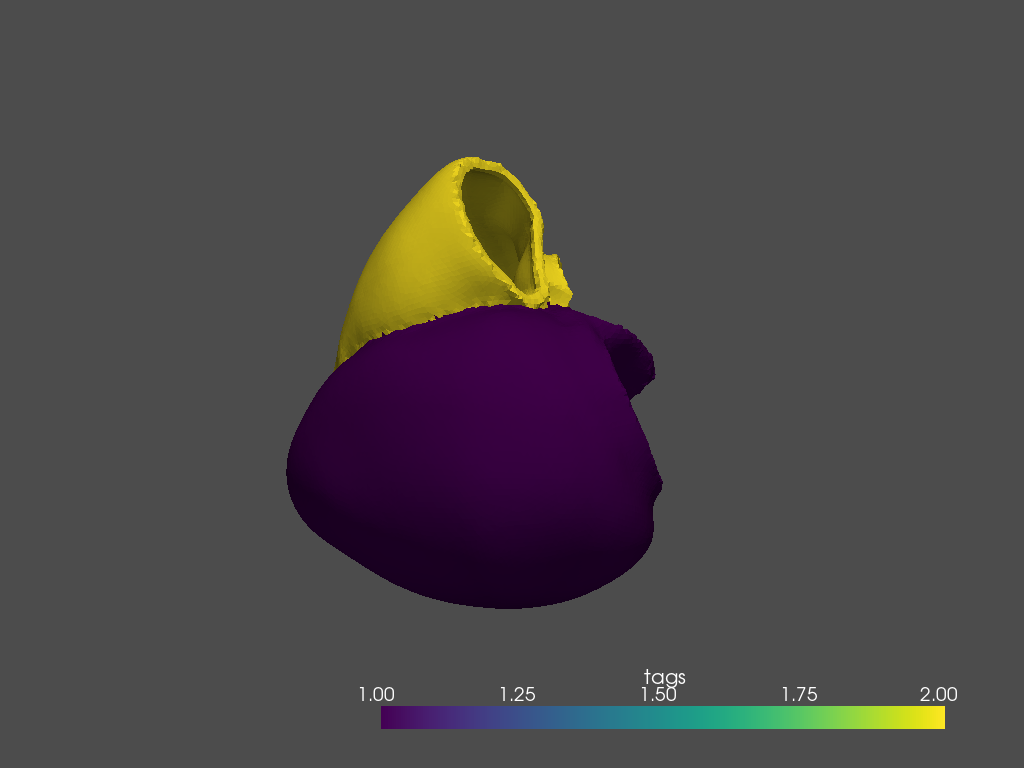

In [4]:
model.plot_mesh(show_edges=False)

In [5]:
file_path = r"C:\Users\xuhu\Downloads\2019_Lopez_torsoPAP_tetraVol-Labeled.vtk\torsoPAP_tetraVol-Labeled_ORIGINAL_full.vtk"
torso = pyvista.read(file_path)

Organids_array = torso["OrganID"]
organ_id_to_plot = 7
# ribs = torso.threshold([organ_id_to_plot - 0.1, organ_id_to_plot + 0.1], scalars="OrganID")
heart = torso.threshold([organ_id_to_plot - 0.1, organ_id_to_plot + 0.1], scalars="OrganID")


In [6]:
fix_points = []

# Iterate over caps in the left ventricle
for cap in model.left_ventricle.caps:
    fix_points.append(cap.centroid)

# Iterate over caps in the right ventricle
for cap in model.right_ventricle.caps:
    fix_points.append(cap.centroid)

# Iterate over apex points in the left ventricle
for apex in model.left_ventricle.apex_points:
    fix_points.append(apex.xyz)

# Iterate over apex points in the right ventricle
for apex in model.right_ventricle.apex_points:
    fix_points.append(apex.xyz)

# Convert the list of points to a NumPy array
fix_points = np.array(fix_points)


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


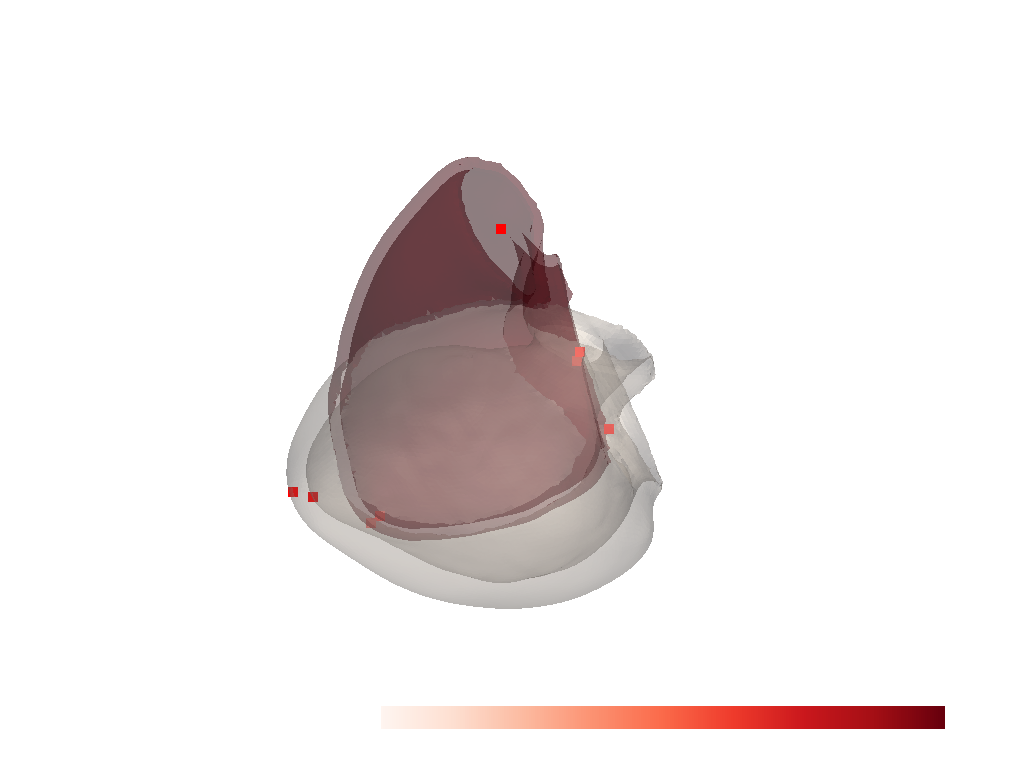

In [7]:
plotter = pyvista.Plotter()

plotter.add_mesh(fix_points, color="red", point_size=10)
plotter.add_mesh(model.mesh, cmap="Reds", opacity=0.3)

# Set the background color and show the plotter
plotter.background_color = "white"
plotter.show()

# rigid trans with scipy

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


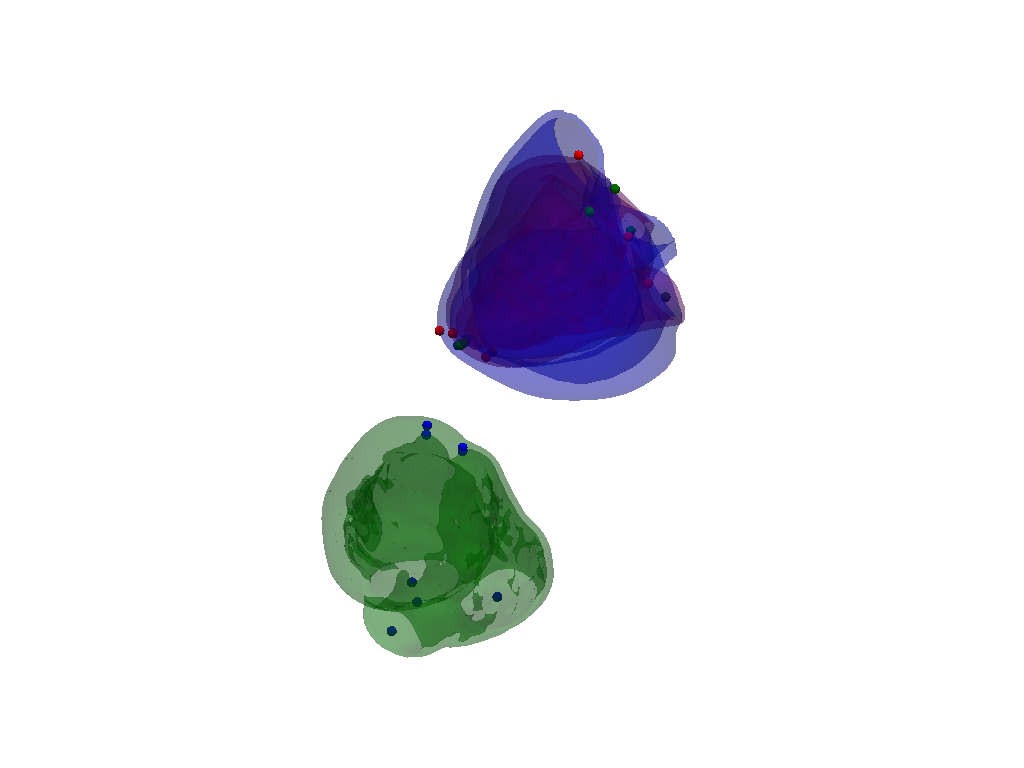

In [8]:

# --------------------------Use rigid transform--------------------------

"""
mitral-valve [ 14.78575795 138.72218537 381.66334608]
aortic-valve [  4.20356264 118.41931813 391.46262272]
tricuspid-valve [-23.12532785  92.6664522  363.28210652]
pulmonary-valve [ 11.8208042   95.51631782 424.01633795]
left_ventricle apex:  [ 66.98953175  76.04045288 353.25812367]
left_ventricle apex:  [ 70.91348565  72.35403913 352.7457911 ]
right_ventricle apex:  [ 45.9829824   77.48032215 333.94426975]
right_ventricle apex:  [ 47.77539122  77.14911944 331.0164472 ]
"""

move_points = np.array([
    [81.90321388, 57.90000882, 205.76663367], # mitral-valve
    [94.35242091, 75.99022315, 213.31654731], # aortic-valve
    [67.14045655, 102.49380179, 216.20654707], # tricuspid-valve
    [121.58912558, 89.76497459, 223.29557159], # pulmonary-valve
    [70.87069056682236, 84.83837198547876, 295.6765864478138], # left endo
    [70.54655746919204, 84.50457846174797, 297.2737993295601], # left epi
    [76.04229182019685, 66.53094359081156, 297.7182142431582], # right endo
    [75.08606835375224, 66.33759424571653, 302.2811669120656], # right epi   
])

moving_model = heart

# Define the initial transformation parameters
random_quaternion = Rotation.random().as_quat()
initial_params = np.zeros(7)
initial_params[:3] = np.random.rand(3)  # Random translation
initial_params[3:] = random_quaternion

# Constrain quaternion components to ensure they remain valid
constraints = ({'type': 'eq', 'fun': lambda params: 1.0 - np.sum(params[3:] ** 2)})

# Define the rigid transform function
def rigid_transform(params, points):
    translation = params[:3]
    quaternion = params[3:]
    quaternion /= np.linalg.norm(quaternion)
    rotation_matrix = Rotation.from_quat(quaternion).as_matrix()
    transformed_points = np.dot(points - translation, rotation_matrix.T)
    return transformed_points

# Define the objective function
def objective_function(params, fixed_points, moving_points):
    transformed_points = rigid_transform(params, moving_points)
    distance = np.sum(np.square(transformed_points - fixed_points))
    return distance

result = minimize(objective_function, initial_params, args=(fix_points, move_points), method='L-BFGS-B', constraints=constraints)

optimal_params = result.x

transformed_move_points = rigid_transform(optimal_params, move_points)

fix_cloud = pyvista.PolyData(fix_points)
move_cloud = pyvista.PolyData(move_points)
transformed_move_cloud = pyvista.PolyData(transformed_move_points)

p2 = pyvista.Plotter()
p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)

# Get the optimized parameters
optimal_params = result.x

# Apply the optimal transformation to the moving model
transformed_model = moving_model.copy()
transformed_model.points = rigid_transform(optimal_params, moving_model.points)

# Visualize the original moving model and the transformed model
p2.add_mesh(moving_model, color="green", opacity=0.3)
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3)

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


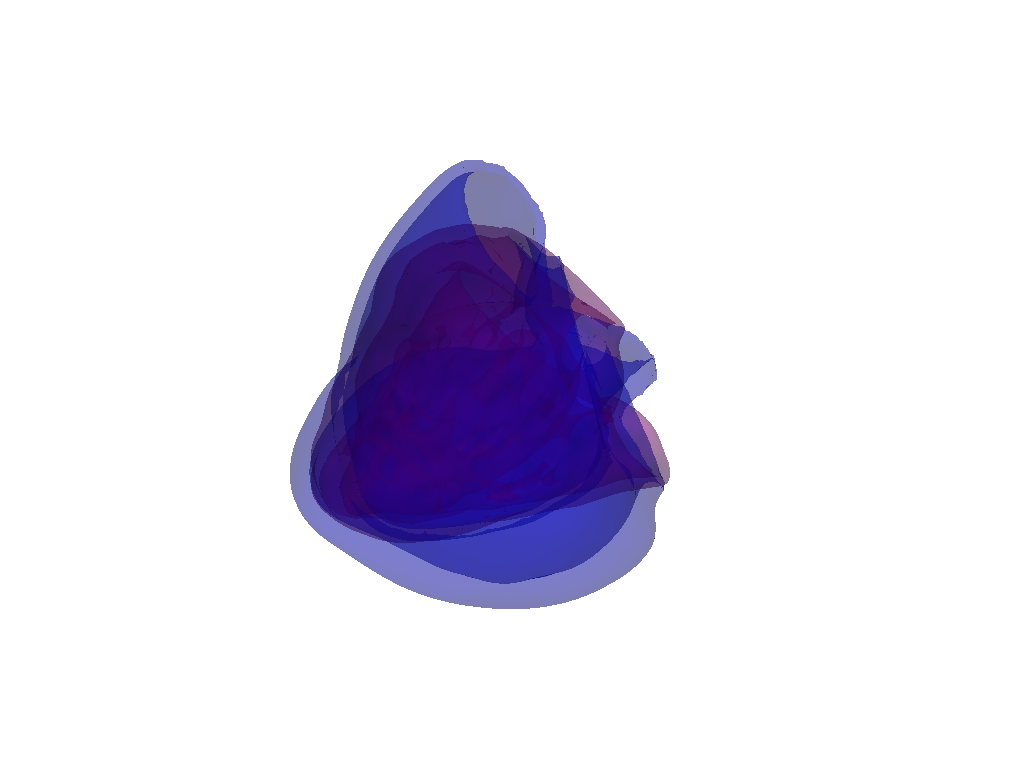

In [9]:
p2 = pyvista.Plotter()
# Visualize the original moving model and the transformed model
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3)


# # Set camera position
# p2.camera_position = 'xy'
# p2.camera.azimuth = 10.0

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

## hausdorff_distance

In [10]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

# Assuming transformed_model and model.mesh are your two mesh models

# Extract points from the mesh vertices
points_transformed = transformed_model.points
points_original = model.mesh.points

# Compute the Hausdorff distance
hausdorff_distance = directed_hausdorff(points_transformed, points_original)[0]

# Output Hausdorff distance
print(f'Hausdorff Distance: {hausdorff_distance}')


Hausdorff Distance: 26.661806656119147


## Mean Surface Distance:
Definition: The mean surface distance is the average distance between each point on the surfaces of two models.
Interpretation: A smaller mean surface distance indicates that the surfaces of the two models are closer, suggesting that the registration result is generally accurate. If the mean surface distance is large, it may indicate significant deviations in certain areas.

## Hausdorff Distance:
Definition: The Hausdorff distance is the maximum distance between points on the surfaces of two models, representing the maximum inconsistency between the two models.
Interpretation: A smaller Hausdorff distance indicates a good overall match, but Hausdorff distance is sensitive to outliers. If there are local inconsistencies, the Hausdorff distance may increase.

## Surface Overlap:
Definition: Surface overlap is the proportion of the overlap region on the surfaces of two models to the total surface area.
Interpretation: A higher surface overlap indicates significant overlap on the surfaces, meaning that the registration result is a good overall match. If the surface overlap is low, it may indicate that some parts of the models are not correctly aligned or matched.
Considering the comprehensive analysis of these three indicators, the following conclusions can be drawn:

If the mean surface distance is small, Hausdorff distance is small, and surface overlap is high, then the registration result is ideal, with good overall consistency on the surfaces.
If the Hausdorff distance is large but the mean surface distance is still small, there may be some local inconsistencies.
If the surface overlap is low, it may be necessary to check if some parts of the models did not align correctly.

In [11]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def downsample_points(points, target_size):
    indices = np.random.choice(len(points), target_size, replace=False)
    return points[indices]

def evaluate_mesh_similarity(transformed_model, original_model):
    # Extract points from the mesh vertices
    points_transformed = transformed_model.points
    points_original = original_model.mesh.points

    # Downsample points if the sizes are different
    if len(points_transformed) > len(points_original):
        points_transformed = downsample_points(points_transformed, len(points_original))
    elif len(points_original) > len(points_transformed):
        points_original = downsample_points(points_original, len(points_transformed))

    # Compute the Hausdorff distance
    hausdorff_distance = directed_hausdorff(points_transformed, points_original)[0]

    # Compute Mean Surface Distance
    mean_surface_distance = np.mean(np.linalg.norm(points_transformed - points_original, axis=1))

    # Estimate Surface Overlap based on volume intersection
    volume_intersection = np.sum(np.minimum(points_transformed[:, 2], points_original[:, 2]))
    volume_union = np.sum(points_transformed[:, 2]) + np.sum(points_original[:, 2]) - volume_intersection
    surface_overlap = volume_intersection / volume_union

    # Output the results
    print(f'Mean Surface Distance: {mean_surface_distance}')
    print(f'Hausdorff Distance: {hausdorff_distance}')
    print(f'Surface Overlap: {surface_overlap}')

# Example usage
# transformed_model and original_model should be replaced with your actual mesh objects
evaluate_mesh_similarity(transformed_model, model)


Mean Surface Distance: 61.7619445333858
Hausdorff Distance: 26.272064126730633
Surface Overlap: 0.9249680448917617


## GetLandmarkTransform - 

In [12]:
def vtkpoints_to_numpy(vtk_points):
    """Convert VTK vtkPoints to NumPy array."""
    num_points = vtk_points.GetNumberOfPoints()
    points_array = np.empty((num_points, 3))

    for i in range(num_points):
        point = vtk_points.GetPoint(i)
        points_array[i] = point

    return points_array


In [13]:
for cap in model.right_ventricle.caps:
    print(cap.name,cap.centroid)

pulmonary-valve [ 11.87729029  95.81072653 423.85163788]
tricuspid-valve [-22.98193342  92.93539604 363.03716106]


In [14]:
# Extract cap centroids from the left and right ventricles
fix_points = [cap.centroid for cap in model.left_ventricle.caps]
fix_points += [cap.centroid for cap in model.right_ventricle.caps]

# Extract apex coordinates from the left and right ventricles
fix_points += [apex.xyz for apex in model.left_ventricle.apex_points]
fix_points += [apex.xyz for apex in model.right_ventricle.apex_points]

# Convert the list of points to a NumPy array
fix_points = np.array(fix_points)
fix_points

array([[  4.12941494, 118.29649081, 391.32786014],
       [ 14.98680954, 139.00226196, 381.86715647],
       [ 11.87729029,  95.81072653, 423.85163788],
       [-22.98193342,  92.93539604, 363.03716106],
       [ 66.92678229,  76.22910099, 352.55582004],
       [ 70.06069878,  71.27226575, 353.05062963],
       [ 45.41901794,  78.01370688, 333.33936308],
       [ 47.67597045,  76.44610331, 331.14411229]])

In [15]:
move_points = np.array([
    [94.35242091, 75.99022315, 213.31654731], # aortic-valve
    [81.90321388, 57.90000882, 205.76663367], # mitral-valve 
    [121.58912558, 89.76497459, 223.29557159], # pulmonary-valve
    [67.14045655, 102.49380179, 216.20654707], # tricuspid-valve
    [70.87069056682236, 84.83837198547876, 295.6765864478138], # left endo
    [70.54655746919204, 84.50457846174797, 297.2737993295601], # left epi
    [76.04229182019685, 66.53094359081156, 297.7182142431582], # right endo
    [75.08606835375224, 66.33759424571653, 302.2811669120656], # right epi   
])



In [16]:
file_path = r"C:\Users\xuhu\Downloads\2019_Lopez_torsoPAP_tetraVol-Labeled.vtk\torsoPAP_tetraVol-Labeled_ORIGINAL_full.vtk"
torso = pyvista.read(file_path)

Organids_array = torso["OrganID"]
organ_id_to_plot = 7
# ribs = torso.threshold([organ_id_to_plot - 0.1, organ_id_to_plot + 0.1], scalars="OrganID")
heart = torso.threshold([organ_id_to_plot - 0.1, organ_id_to_plot + 0.1], scalars="OrganID")


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


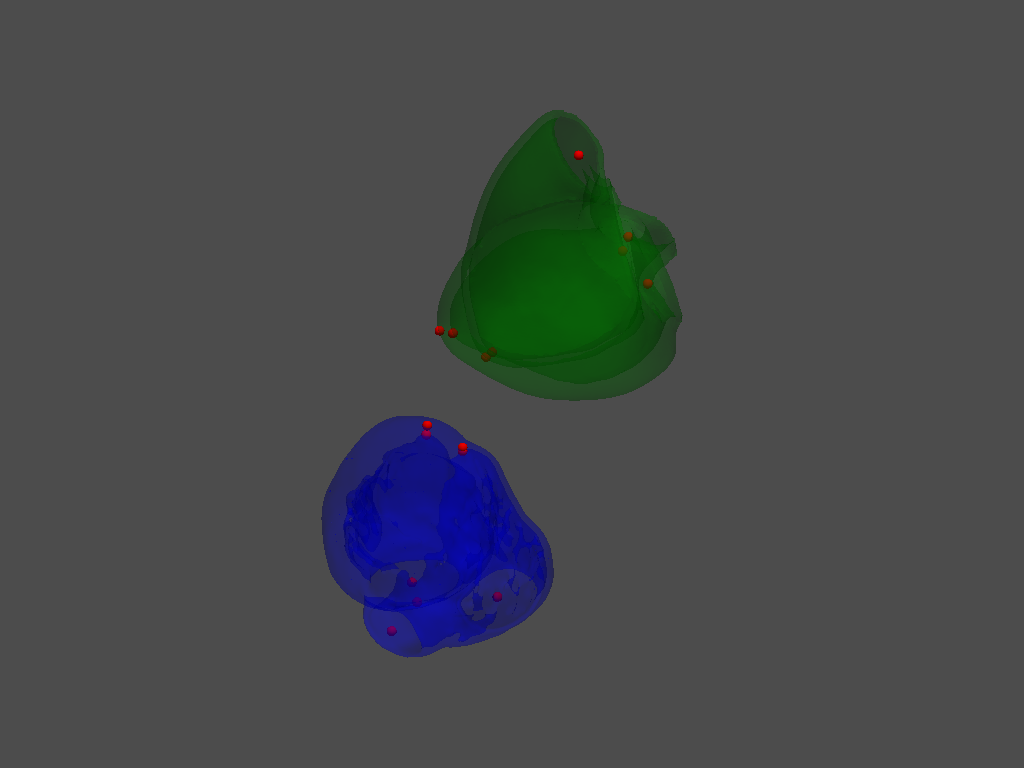

In [17]:
import pyvista as pv

fix_cloud = pv.PolyData(fix_points)
move_cloud = pv.PolyData(move_points)

p = pv.Plotter()
p.add_mesh(move_points, color="red", point_size=10, render_points_as_spheres=True)
p.add_mesh(heart, color="blue", opacity=0.3)

p.add_mesh(fix_points, color="red", point_size=10, render_points_as_spheres=True)
p.add_mesh(model.mesh, color="green", opacity=0.3)

p.show()

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


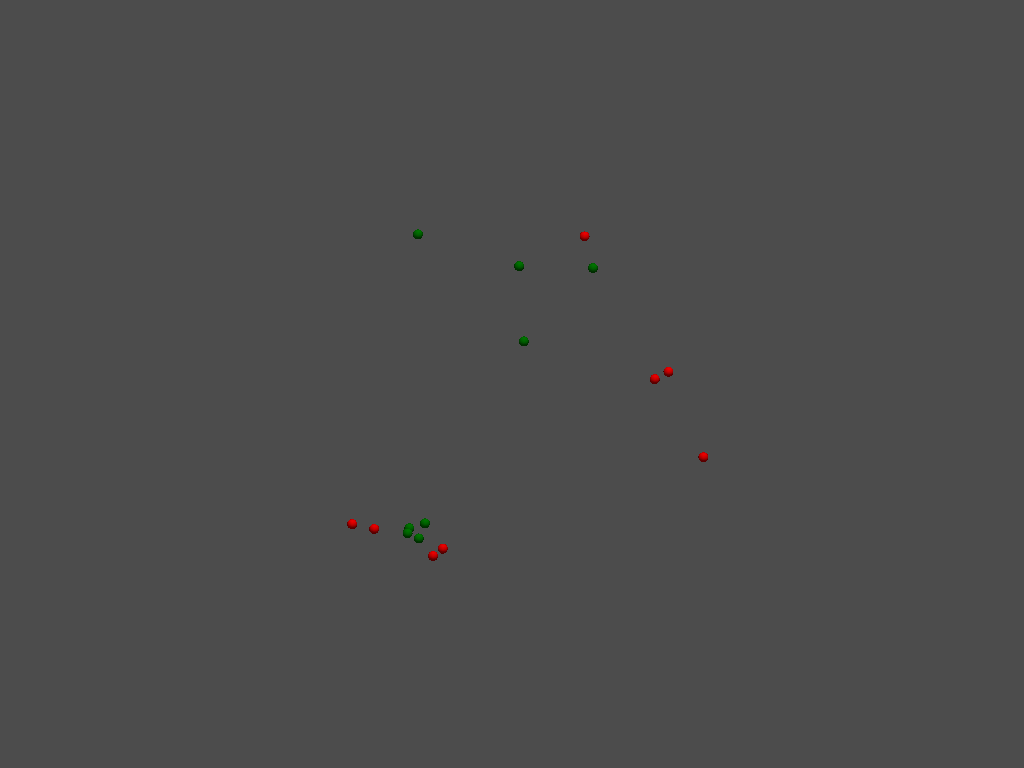

In [18]:
from vtk import vtkLandmarkTransform, vtkPoints, vtkTransform

fix_cloud = pv.PolyData(fix_points)
move_cloud = pv.PolyData(move_points)

fix_vtk_points = vtkPoints()
for point in fix_points:
    fix_vtk_points.InsertNextPoint(point)

move_vtk_points = vtkPoints()
for point in move_points:
    move_vtk_points.InsertNextPoint(point)

landmark_transform = vtkLandmarkTransform()
landmark_transform.SetSourceLandmarks(fix_vtk_points)
landmark_transform.SetTargetLandmarks(move_vtk_points)
landmark_transform.SetModeToRigidBody()
landmark_transform.Update()

transformed_vtk_points = vtkPoints()
landmark_transform.TransformPoints(move_vtk_points, transformed_vtk_points)

transformed_points_np = vtkpoints_to_numpy(transformed_vtk_points)

transformed_move_cloud = pv.PolyData(transformed_points_np)

p2 = pv.Plotter()
p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)
p2.show()


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


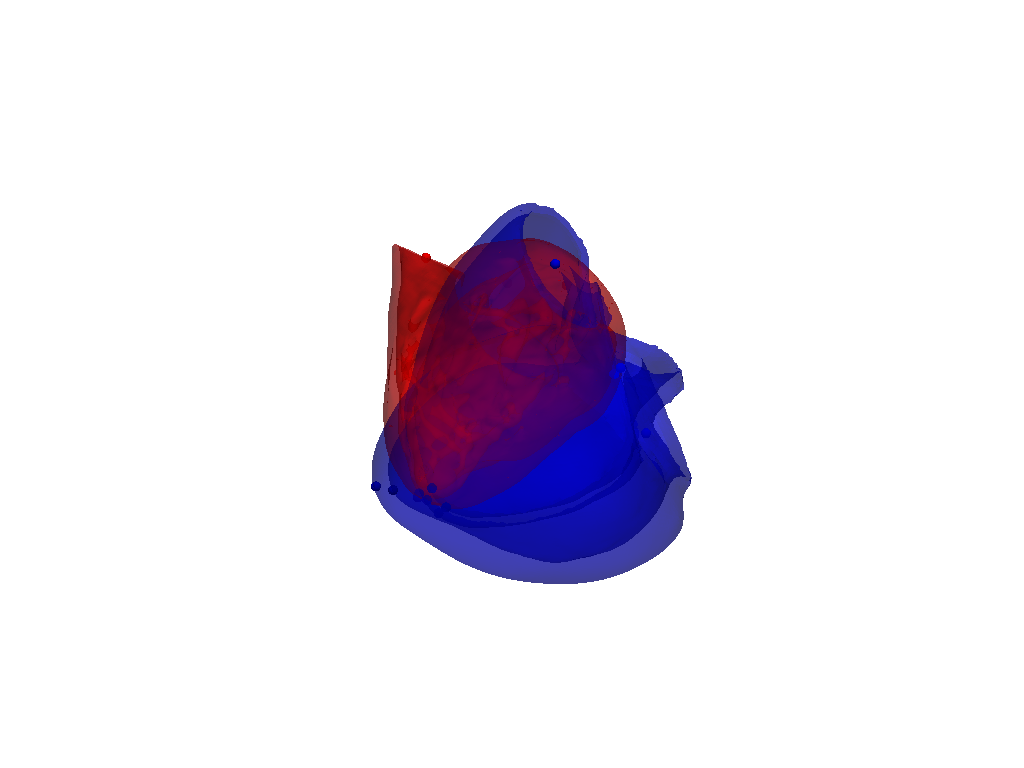

In [19]:
import pyvista as pv
from vtk import vtkLandmarkTransform, vtkPoints, vtkTransform

fix_cloud = pv.PolyData(fix_points)
move_cloud = pv.PolyData(move_points)

# p = pv.Plotter()
# p.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p.add_mesh(model.mesh, color="red", opacity=0.3)
# p.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p.add_mesh(heart, color="blue", opacity=0.3)
# p.show()

fix_vtk_points = vtkPoints()
for point in fix_points:
    fix_vtk_points.InsertNextPoint(point)

move_vtk_points = vtkPoints()
for point in move_points:
    move_vtk_points.InsertNextPoint(point)


"""
establish the mapping relationship between the two spaces
vtkLandmarkTransform facilitates mapping points 
between spaces based on 
user-defined landmark correspondences
"""
landmark_transform = vtkLandmarkTransform()
landmark_transform.SetSourceLandmarks(fix_vtk_points)
landmark_transform.SetTargetLandmarks(move_vtk_points)
landmark_transform.SetModeToRigidBody()
landmark_transform.Update()

matrix = landmark_transform.GetMatrix()

vtk_transform = vtkTransform()
vtk_transform.SetMatrix(matrix)

transformed_move_cloud = move_cloud.copy()
transformed_move_cloud.transform(vtk_transform)


moving_model = heart.copy()

moving_model.transform(vtk_transform)

p2 = pv.Plotter()

p2.add_mesh(fix_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(moving_model, color="red", opacity=0.5)
p2.add_mesh(model.mesh, color="blue", opacity=0.5)

p2.background_color = "white"

p2.show()

In [20]:
evaluate_mesh_similarity(moving_model, model)

Mean Surface Distance: 89.48959116247102
Hausdorff Distance: 55.883663773759686
Surface Overlap: 0.9081089392079954


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


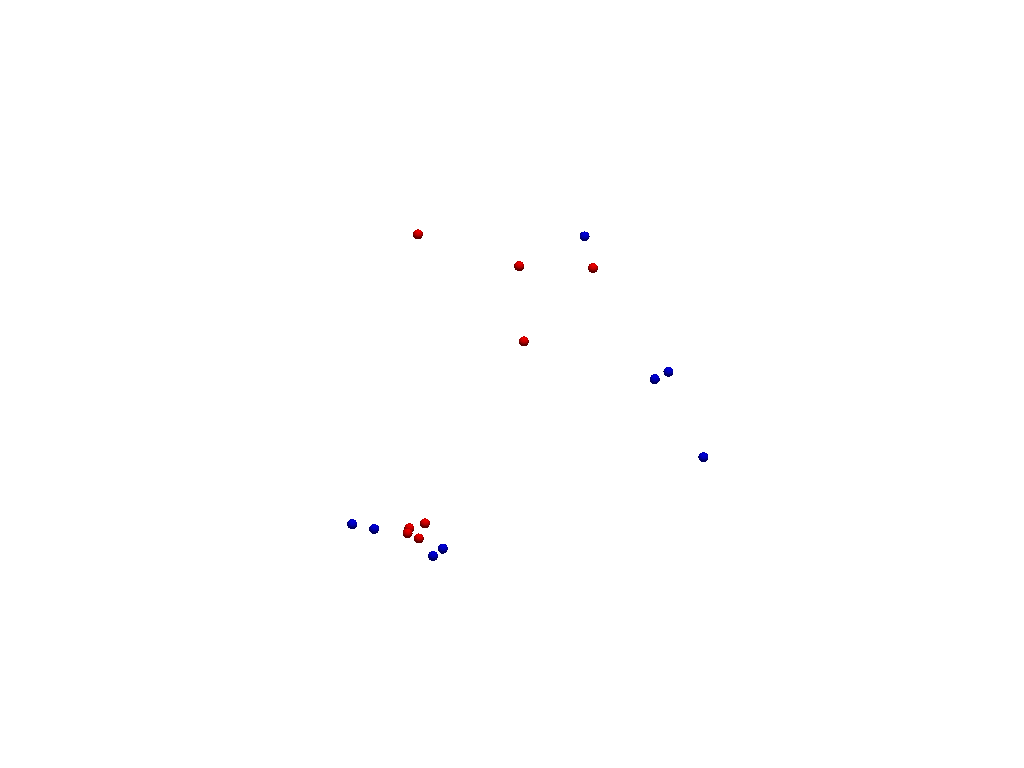

In [21]:
p2 = pv.Plotter()

p2.add_mesh(fix_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.background_color = "white"

p2.show()

In [22]:
import numpy as np
from vtk import vtkPolyData, vtkPoints

fix_points = fix_cloud.points
transformed_move_points = transformed_move_cloud.points

sort_indices = np.argsort(fix_points[:, 0]) 

sorted_fix_points = fix_points[sort_indices]
sorted_transformed_move_points = transformed_move_points[sort_indices]

vtk_fix_points = vtkPoints()
vtk_transformed_move_points = vtkPoints()

for point in sorted_fix_points:
    vtk_fix_points.InsertNextPoint(point)

for point in sorted_transformed_move_points:
    vtk_transformed_move_points.InsertNextPoint(point)

vtk_fix_cloud = vtkPolyData()
vtk_fix_cloud.SetPoints(vtk_fix_points)

vtk_transformed_move_cloud = vtkPolyData()
vtk_transformed_move_cloud.SetPoints(vtk_transformed_move_points)


# Rigid: rotation + translation

# Similarity: rigid + isotropic scaling

# Affine: rigid + scaling + shear

# SetModeToSimilarity

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


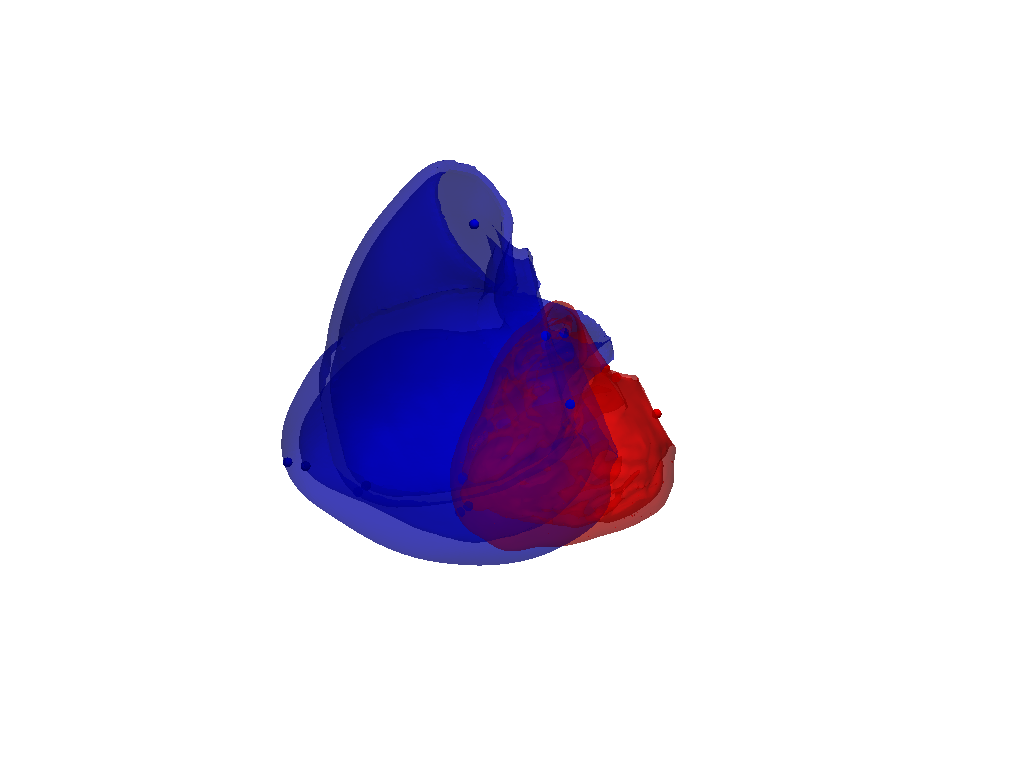

In [30]:
import pyvista as pv
from vtk import vtkLandmarkTransform, vtkPoints, vtkTransform

fix_cloud = pv.PolyData(fix_points)
move_cloud = pv.PolyData(move_points)

# p = pv.Plotter()
# p.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p.add_mesh(model.mesh, color="red", opacity=0.3)
# p.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p.add_mesh(heart, color="blue", opacity=0.3)
# p.show()

fix_vtk_points = vtkPoints()
for point in fix_cloud.points:
    fix_vtk_points.InsertNextPoint(point)

move_vtk_points = vtkPoints()
for point in transformed_move_cloud.points:
    move_vtk_points.InsertNextPoint(point)


"""
establish the mapping relationship between the two spaces
vtkLandmarkTransform facilitates mapping points 
between spaces based on 
user-defined landmark correspondences
"""
landmark_transform = vtkLandmarkTransform()
landmark_transform.SetSourceLandmarks(fix_vtk_points)
landmark_transform.SetTargetLandmarks(move_vtk_points)
landmark_transform.SetModeToSimilarity()
landmark_transform.Update()

matrix = landmark_transform.GetMatrix()

vtk_transform = vtkTransform()
vtk_transform.SetMatrix(matrix)

transformed_move_cloud = move_cloud.copy()
transformed_move_cloud.transform(vtk_transform)


moving_model = heart.copy()

moving_model.transform(vtk_transform)

p2 = pv.Plotter()

p2.add_mesh(fix_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(moving_model, color="red", opacity=0.5)
p2.add_mesh(model.mesh, color="blue", opacity=0.5)

p2.background_color = "white"

p2.show()

In [31]:
evaluate_mesh_similarity(moving_model,model)

Mean Surface Distance: 84.60428527501776
Hausdorff Distance: 37.223072839299036
Surface Overlap: 0.8839238611614016


# SetModeToAffine

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


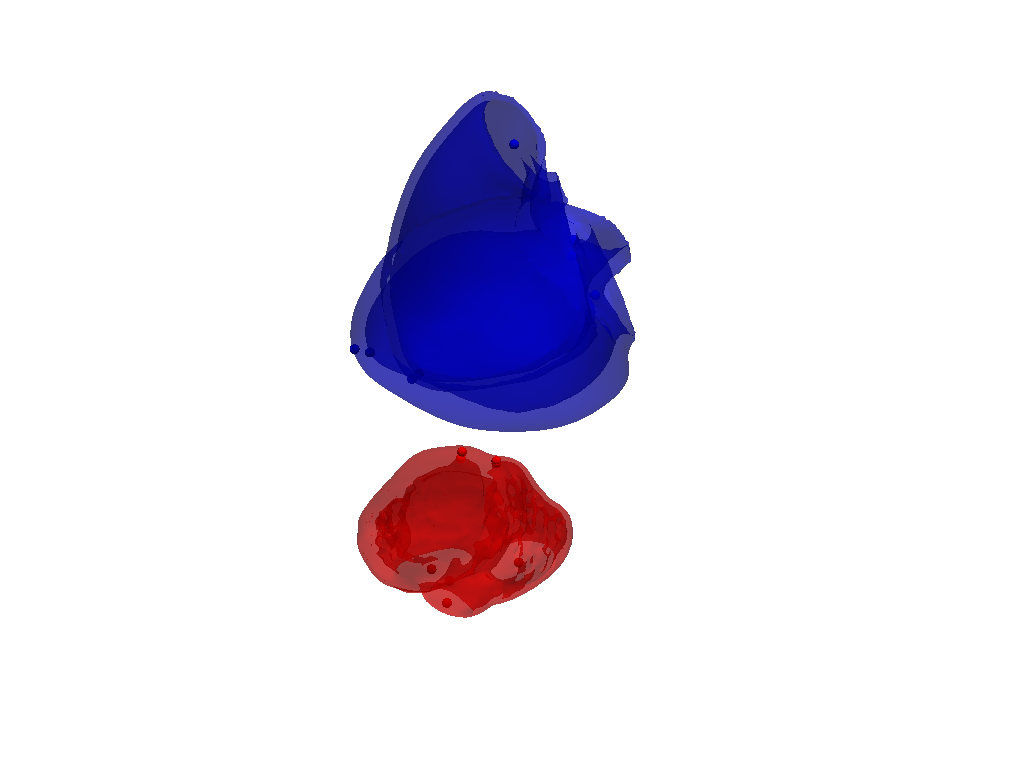

In [32]:
import pyvista as pv
from vtk import vtkLandmarkTransform, vtkPoints, vtkTransform

fix_cloud = pv.PolyData(fix_points)
move_cloud = pv.PolyData(move_points)

# p = pv.Plotter()
# p.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p.add_mesh(model.mesh, color="red", opacity=0.3)
# p.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p.add_mesh(heart, color="blue", opacity=0.3)
# p.show()

fix_vtk_points = vtkPoints()
for point in fix_cloud.points:
    fix_vtk_points.InsertNextPoint(point)

move_vtk_points = vtkPoints()
for point in transformed_move_cloud.points:
    move_vtk_points.InsertNextPoint(point)


"""
establish the mapping relationship between the two spaces
vtkLandmarkTransform facilitates mapping points 
between spaces based on 
user-defined landmark correspondences
"""
landmark_transform = vtkLandmarkTransform()
landmark_transform.SetSourceLandmarks(fix_vtk_points)
landmark_transform.SetTargetLandmarks(move_vtk_points)
landmark_transform.SetModeToAffine()
landmark_transform.Update()

matrix = landmark_transform.GetMatrix()

vtk_transform = vtkTransform()
vtk_transform.SetMatrix(matrix)

transformed_move_cloud = move_cloud.copy()
transformed_move_cloud.transform(vtk_transform)


moving_model = heart.copy()

moving_model.transform(vtk_transform)

p2 = pv.Plotter()

p2.add_mesh(fix_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(moving_model, color="red", opacity=0.5)
p2.add_mesh(model.mesh, color="blue", opacity=0.5)

p2.background_color = "white"

p2.show()

In [33]:
evaluate_mesh_similarity(moving_model,model)

Mean Surface Distance: 137.11878828332877
Hausdorff Distance: 115.22211970842146
Surface Overlap: 0.659226533162062


# Rigid transform with ICP -  cloud points


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


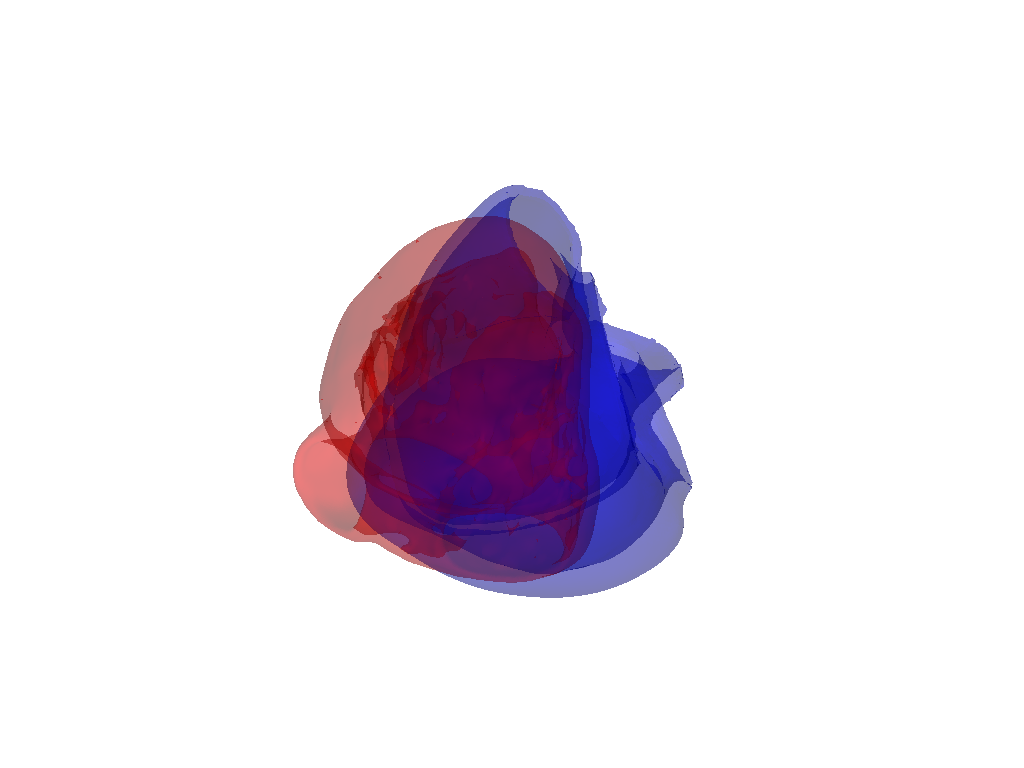

In [43]:
# moving_model = transformed_model.copy()
mesh_a = move_cloud.copy() # moving model
mesh_b = fix_cloud.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(1000)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()

model_h = heart.copy()
aligned = model_h.transform(icp.GetMatrix())

p2 = pyvista.Plotter()


# p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3) # orginal model
p2.add_mesh(aligned, color="red", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()


In [44]:
evaluate_mesh_similarity(aligned, model)

Mean Surface Distance: 63.62740420824165
Hausdorff Distance: 27.642929583974425
Surface Overlap: 0.9246471876209669


# Rigid transform with ICP -  mesh

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


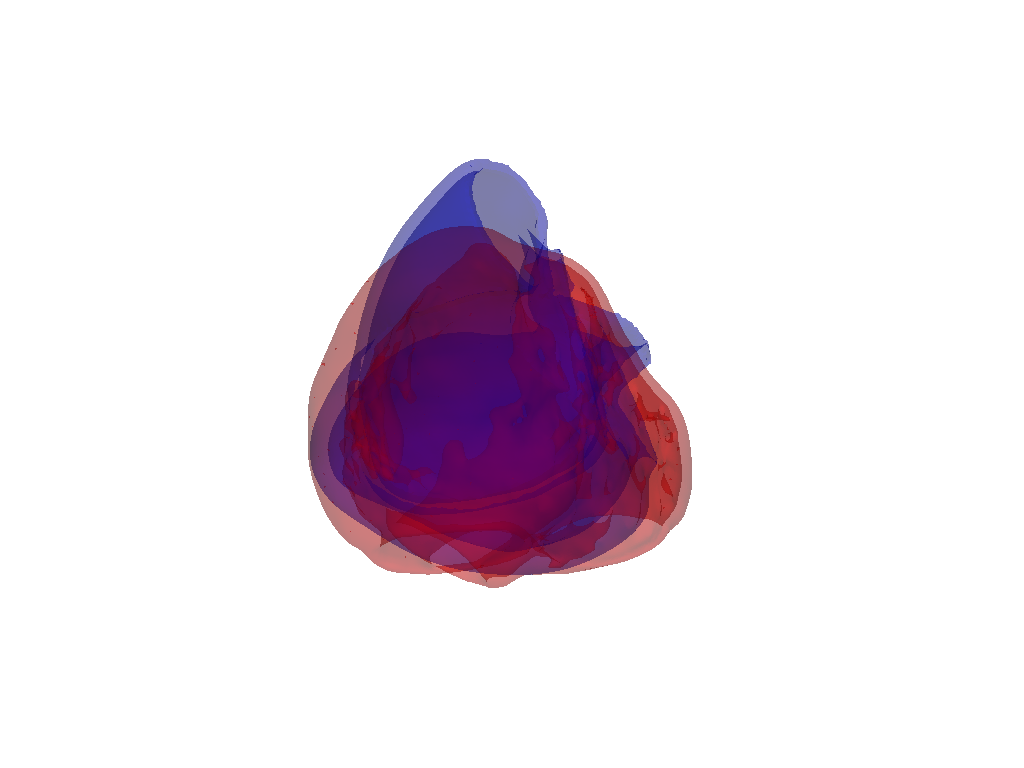

In [42]:
# moving_model = transformed_model.copy()
mesh_a = heart.copy() # moving model
mesh_b = model.mesh.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(1000)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()

model_h = heart.copy()
aligned = model_h.transform(icp.GetMatrix())

p2 = pyvista.Plotter()


# p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3) # orginal model
p2.add_mesh(aligned, color="red", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()


In [39]:
evaluate_mesh_similarity(aligned, model)

Mean Surface Distance: 63.570652099163595
Hausdorff Distance: 26.250492095906388
Surface Overlap: 0.9232235081675546


# scipy + ICP

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


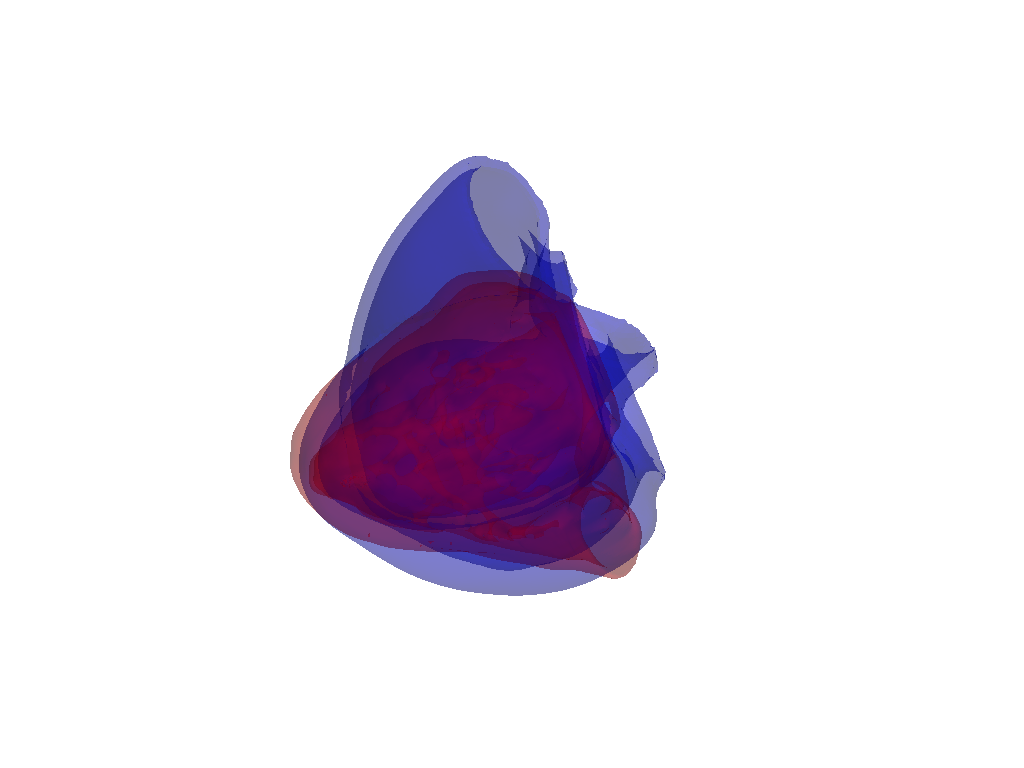

In [45]:
# moving_model = transformed_model.copy()
mesh_a = transformed_model.copy() # moving model
mesh_b = model.mesh.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(1000)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()


aligned = mesh_a.transform(icp.GetMatrix())

p2 = pyvista.Plotter()

# p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3) # orginal model
p2.add_mesh(aligned, color="red", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()


In [46]:
evaluate_mesh_similarity(aligned, model)

Mean Surface Distance: 62.2476408641044
Hausdorff Distance: 24.39560576110074
Surface Overlap: 0.9213922501212253


In [47]:
import vtk

# moving_model = transformed_model.copy()


# p2 = pyvista.Plotter()
# p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)



mesh_a = transformed_move_cloud.copy() # moving model
mesh_b = fix_cloud.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.000001)
icp.SetMaximumNumberOfIterations(100)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()


transformation_matrix = icp.GetMatrix()

transform = vtk.vtkTransform()
transform.SetMatrix(transformation_matrix)
# Assuming trans_model is a PyVista UnstructuredGrid object
trans_model = transformed_model.copy()

# Create a PyVista transform object
vtk_transform = vtk.vtkTransform()
vtk_transform.SetMatrix(icp.GetMatrix())

# Apply the transformation to the PyVista mesh
trans_model.transform(vtk_transform)

# aligned = mesh_a.transform(icp.GetMatrix())




UnstructuredGrid (0x2648320f1c0)
  N Cells:    2714010
  N Points:   709914
  X Bounds:   -4.545e+01, 6.004e+01
  Y Bounds:   7.373e+01, 1.827e+02
  Z Bounds:   4.499e+02, 5.506e+02
  N Arrays:   2

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


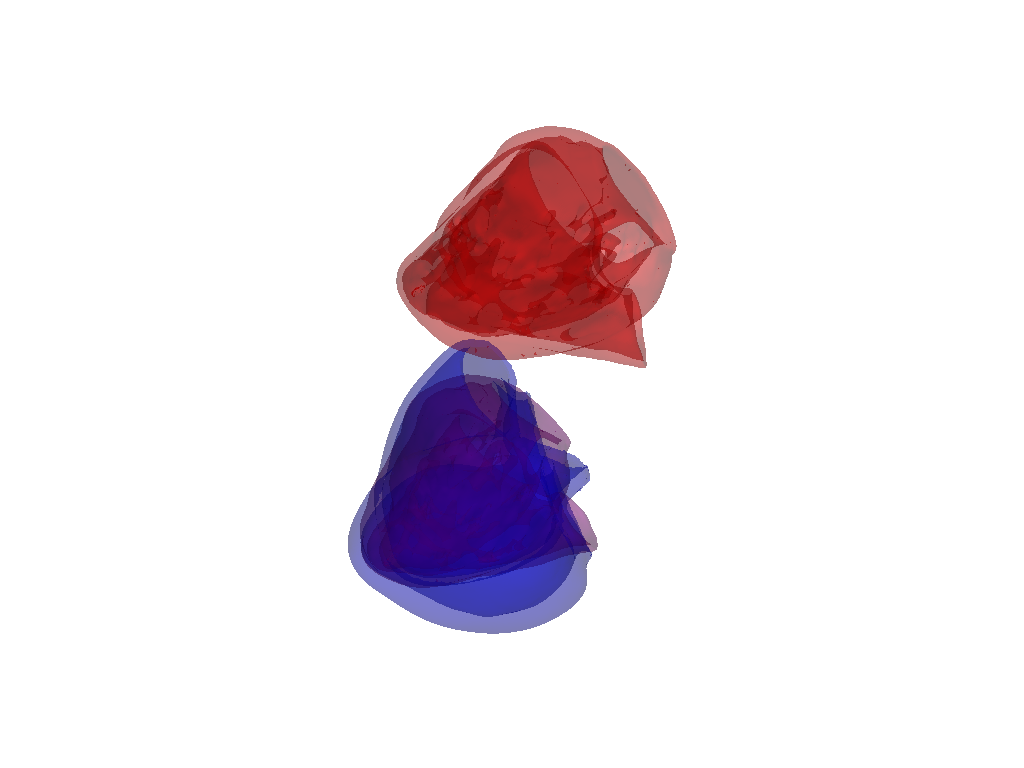

In [49]:
p2 = pyvista.Plotter()

p2.add_mesh(model.mesh, color="blue", opacity=0.3)
p2.add_mesh(transformed_model, color="purple", opacity=0.3) # orginal model
p2.add_mesh(trans_model, color="red", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


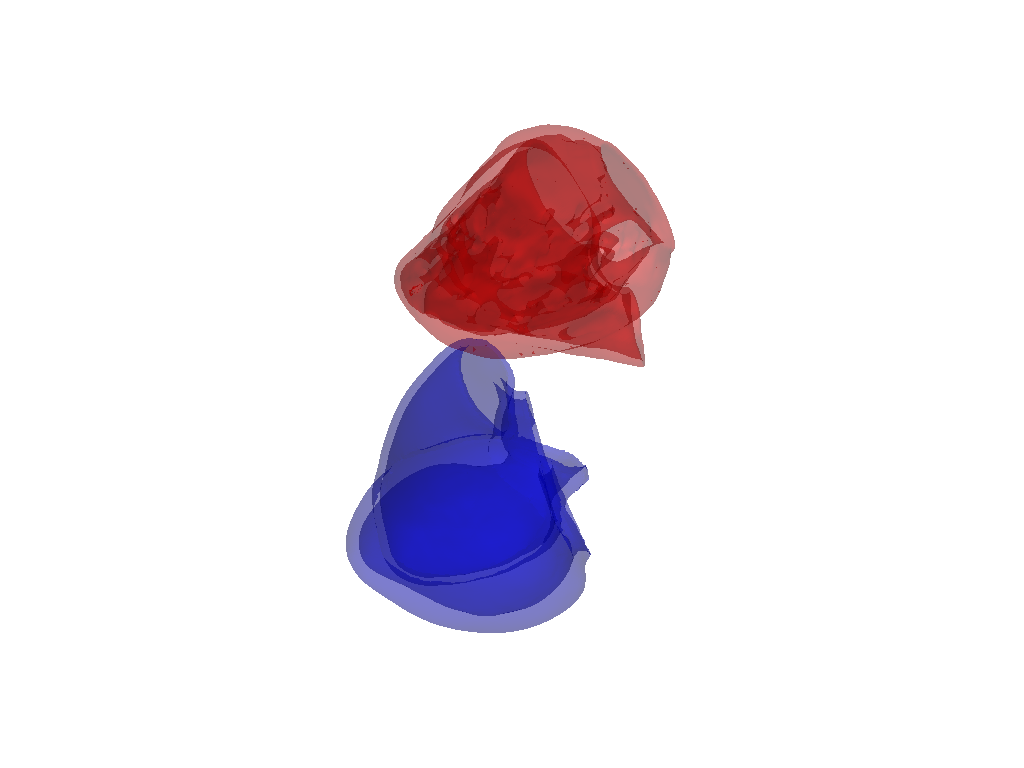

In [50]:
p2 = pyvista.Plotter()

p2.add_mesh(model.mesh, color="blue", opacity=0.3)
# p2.add_mesh(transformed_model, color="purple", opacity=0.3) # orginal model
p2.add_mesh(trans_model, color="red", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [ ]:
evaluate_mesh_similarity(aligned, model)

## without apex

c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


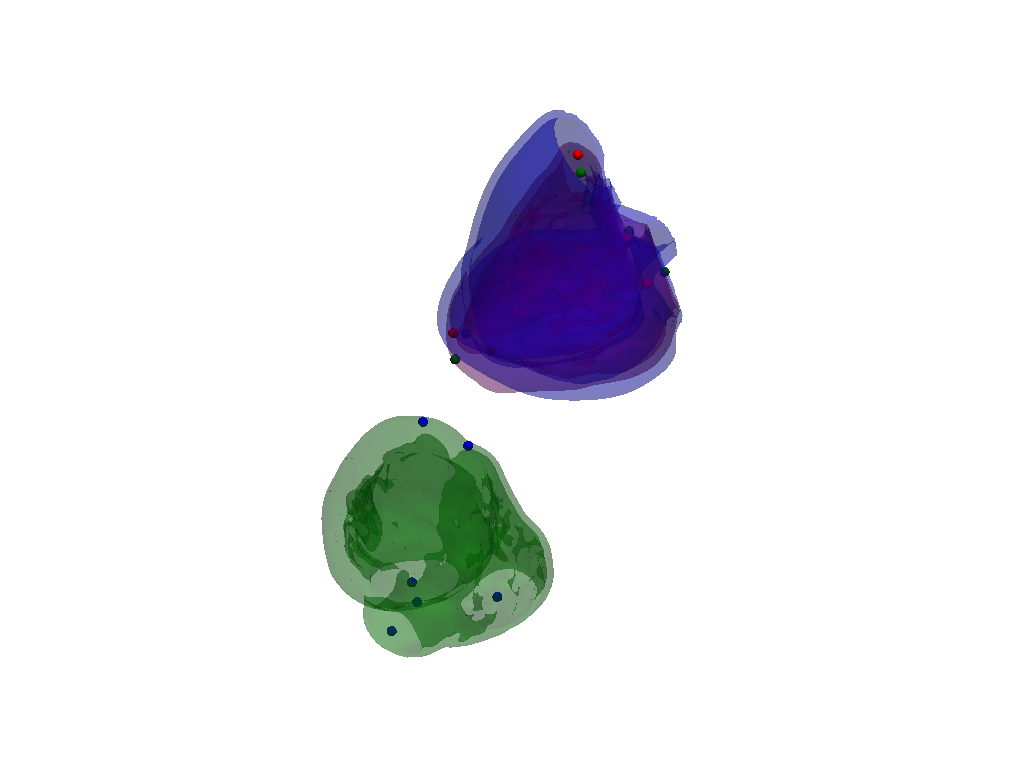

In [ ]:

# --------------------------Use rigid transform--------------------------

# 生成固定和移动模型的点云数据
fix_points = np.array([
    [14.83343254, 138.84328635, 381.69040887],
    [4.05351488, 118.41811815, 391.29761896],
    [-23.05345085, 92.81499077, 363.12556701],
    [12.11718736, 95.61561885, 424.1137484],
    [66.62810203, 76.12861982, 352.41549411],
    [45.85018296, 77.32545243, 333.88303795],
])

move_points = np.array([
    [81.90321388, 57.90000882, 205.76663367],
    [94.35242091, 75.99022315, 213.31654731],
    [67.14045655, 102.49380179, 216.20654707],
    [121.58912558, 89.76497459, 223.29557159],
    [67.23725112873248, 84.63169515538843, 296.5102709741695],
    [74.54353173118157, 63.020954005473115, 302.25073384261583],
])

moving_model = heart

# Define the initial transformation parameters
random_quaternion = Rotation.random().as_quat()
initial_params = np.zeros(7)
initial_params[:3] = np.random.rand(3)  # Random translation
initial_params[3:] = random_quaternion

# Constrain quaternion components to ensure they remain valid
constraints = ({'type': 'eq', 'fun': lambda params: 1.0 - np.sum(params[3:] ** 2)})

# Define the rigid transform function
def rigid_transform(params, points):
    translation = params[:3]
    quaternion = params[3:]
    quaternion /= np.linalg.norm(quaternion)
    rotation_matrix = Rotation.from_quat(quaternion).as_matrix()
    transformed_points = np.dot(points - translation, rotation_matrix.T)
    return transformed_points

# Define the objective function
def objective_function(params, fixed_points, moving_points):
    transformed_points = rigid_transform(params, moving_points)
    distance = np.sum(np.square(transformed_points - fixed_points))
    return distance

# 进行最小化优化
result = minimize(objective_function, initial_params, args=(fix_points, move_points), method='L-BFGS-B', constraints=constraints)

# 获取最优参数
optimal_params = result.x

# 获取刚性变换后的移动模型点云
transformed_move_points = rigid_transform(optimal_params, move_points)

# 创建PyVista点云对象
fix_cloud = pyvista.PolyData(fix_points)
move_cloud = pyvista.PolyData(move_points)
transformed_move_cloud = pyvista.PolyData(transformed_move_points)

# 显示固定和移动模型以及配准后的模型
p2 = pyvista.Plotter()
p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)

# Get the optimized parameters
optimal_params = result.x

# Apply the optimal transformation to the moving model
transformed_model = moving_model.copy()
transformed_model.points = rigid_transform(optimal_params, moving_model.points)

# Visualize the original moving model and the transformed model
p2.add_mesh(moving_model, color="green", opacity=0.3)
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3)



# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [ ]:
import vtk

# moving_model = transformed_model.copy()


# p2 = pyvista.Plotter()
# p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)



mesh_a = transformed_move_cloud.copy() # moving model
mesh_b = fix_cloud.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(100)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()


# 获取变换矩阵
transformation_matrix = icp.GetMatrix()

# 创建 vtkTransform 对象并应用变换
transform = vtk.vtkTransform()
transform.SetMatrix(transformation_matrix)
# Assuming trans_model is a PyVista UnstructuredGrid object
trans_model = transformed_model.copy()

# Create a PyVista transform object
vtk_transform = vtk.vtkTransform()
vtk_transform.SetMatrix(icp.GetMatrix())

# Apply the transformation to the PyVista mesh
trans_model.transform(vtk_transform)

# aligned = mesh_a.transform(icp.GetMatrix())




UnstructuredGrid (0x1c62660e700)
  N Cells:    2714010
  N Points:   709914
  X Bounds:   -3.165e+01, 8.074e+01
  Y Bounds:   5.854e+01, 1.586e+02
  Z Bounds:   3.325e+02, 4.260e+02
  N Arrays:   2

c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


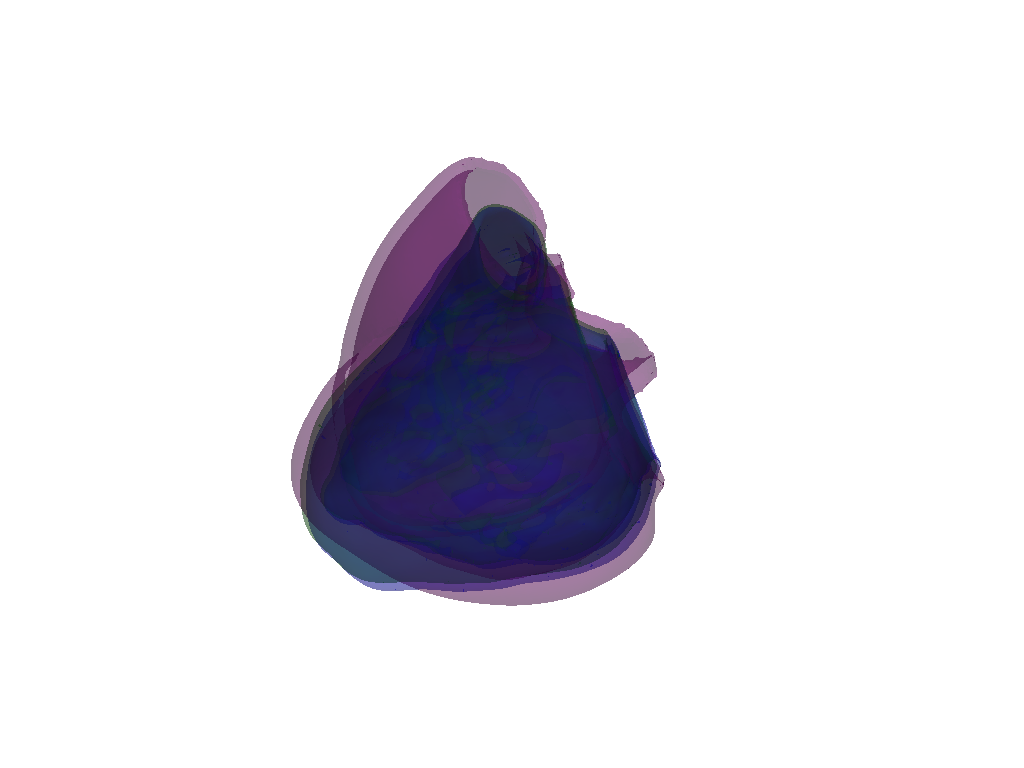

In [ ]:
p2 = pyvista.Plotter()

p2.add_mesh(model.mesh, color="purple", opacity=0.3)
p2.add_mesh(transformed_model, color="blue", opacity=0.3) # orginal model
p2.add_mesh(trans_model, color="green", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


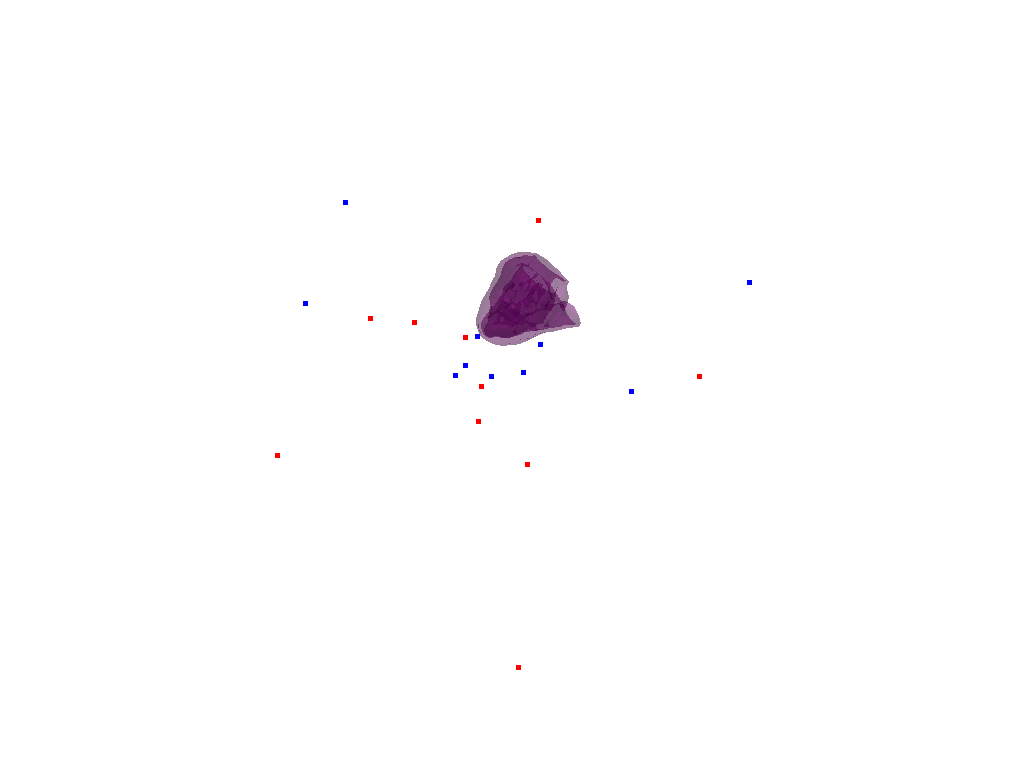

In [ ]:
# 显示固定和移动模型以及配准后的模型
p2 = pyvista.Plotter()
# p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)

# Get the optimized parameters
optimal_params = result.x

# Apply the optimal transformation to the moving model
transformed_model = moving_model.copy()
transformed_model.points = rigid_transform(optimal_params, moving_model.points)

electrode_positions = np.array([
    [x, y, z] for x, y, z in [
        [91.69106809237354, 167.4055272828183, 251.0416838617331],  # V1
        [114.07772933063883, 123.13918227704727, 291.5674747053013],  # V2
        [97.01364431022192, 109.7927312489943, 317.44575378942824],  # V3
        [81.88880486815538, 71.3859176743268, 349.4243690358569],  # V4
        [98.99550734014053, 15.879947224122954, 348.26233938958114],  # V5
        [106.23537044908527, -44.085603837273695, 329.16199248487465],  # V6
        [170.75567690191764, 234.51300755277248, 77.85629801985534],  # RA
        [262.9539413249434, -2.9189733795951724, 261.5745131716608],  # LA
        [-134.9640236606803, 197.05542132895272, 257.6409644703581],  # RL
        [-70.4506948627224, 22.20437217827933, 400.2792599184596]  # LL
    ]
])

transformed_electrodes = rigid_transform(optimal_params, electrode_positions)

# Visualize the original moving model and the transformed model
# p2.add_mesh(moving_model, color="green", opacity=0.3)
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
# p2.add_mesh(model.mesh, color="blue", opacity=0.3)
p2.add_mesh(transformed_electrodes, color="blue", opacity=1)
# p2.add_mesh(electrode_positions, color="red", opacity=1)

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [ ]:
from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform

mesh_a = model.mesh
mesh_b = heart

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(10000)
icp.SetMaximumMeanDistance(.00001)
icp.SetMaximumNumberOfIterations(5000)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()

aligned = mesh_a.transform(icp.GetMatrix())


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


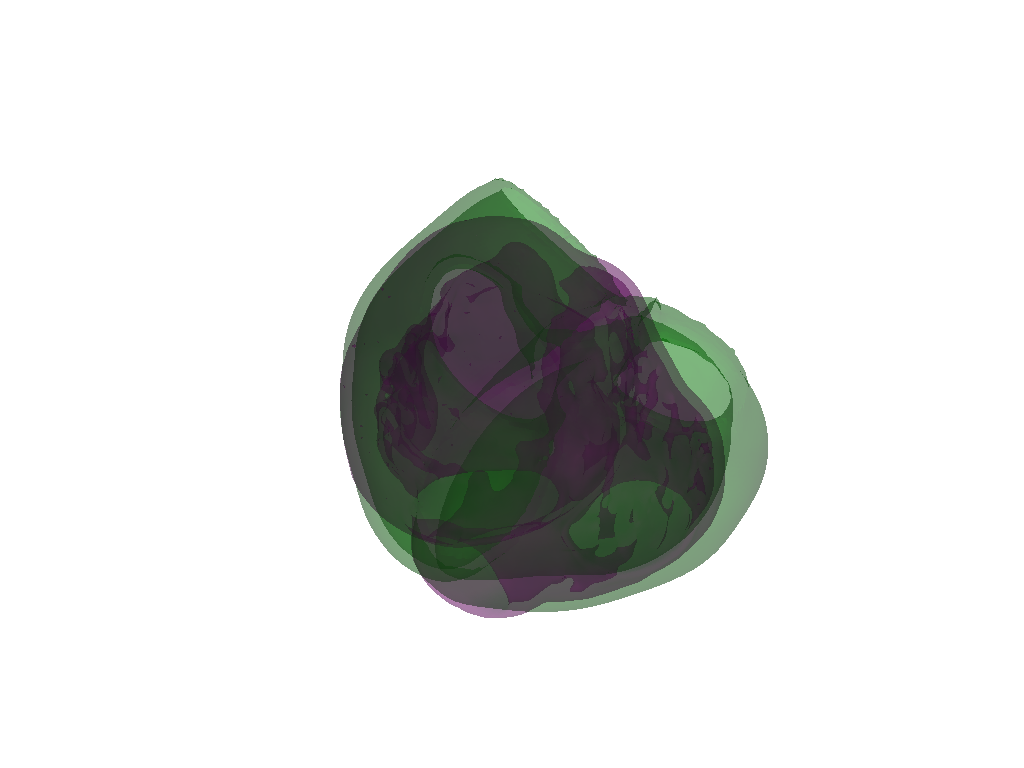

In [ ]:
p2 = pyvista.Plotter()

# Visualize the original moving model and the transformed model
# p2.add_mesh(model.mesh, color="green", opacity=0.1)
p2.add_mesh(mesh_b, color="purple", opacity=0.3)
p2.add_mesh(aligned, color="green", opacity=0.3)

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [ ]:
from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform

# fix_cloud = pv.PolyData(fix_points)
# move_cloud = pv.PolyData(move_points)

# mesh_a = fix_cloud.copy()
# mesh_b = move_cloud.copy()

mesh_a = model.mesh
mesh_b = heart

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)
icp.GetLandmarkTransform().SetModeToSimilarity()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(.00001)
icp.SetMaximumNumberOfIterations(500)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()

aligned = mesh_a.transform(icp.GetMatrix())


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


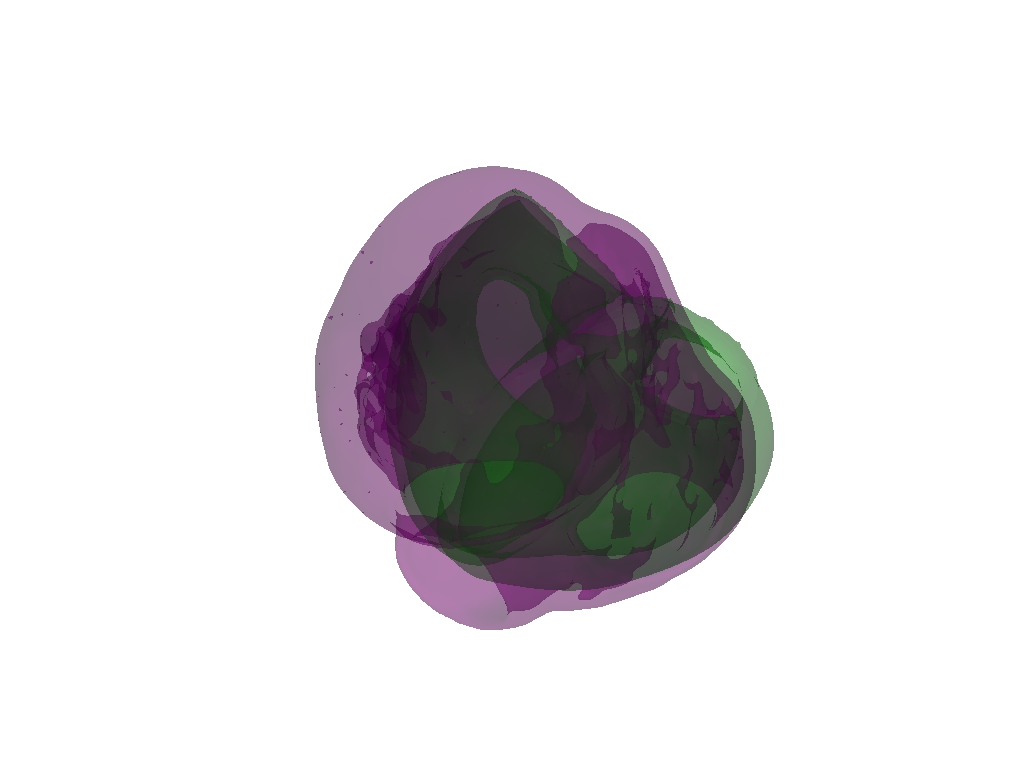

In [ ]:
p2 = pyvista.Plotter()

# Visualize the original moving model and the transformed model
# p2.add_mesh(model.mesh, color="green", opacity=0.1)
p2.add_mesh(mesh_b, color="purple", opacity=0.3)
p2.add_mesh(aligned, color="green", opacity=0.3)

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [ ]:
from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform

# fix_cloud = pv.PolyData(fix_points)
# move_cloud = pv.PolyData(move_points)

# mesh_a = fix_cloud.copy()
# mesh_b = move_cloud.copy()

mesh_a = model.mesh
mesh_b = heart

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)
icp.GetLandmarkTransform().SetModeToAffine()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(.00001)
icp.SetMaximumNumberOfIterations(500)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()

aligned = mesh_a.transform(icp.GetMatrix())


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


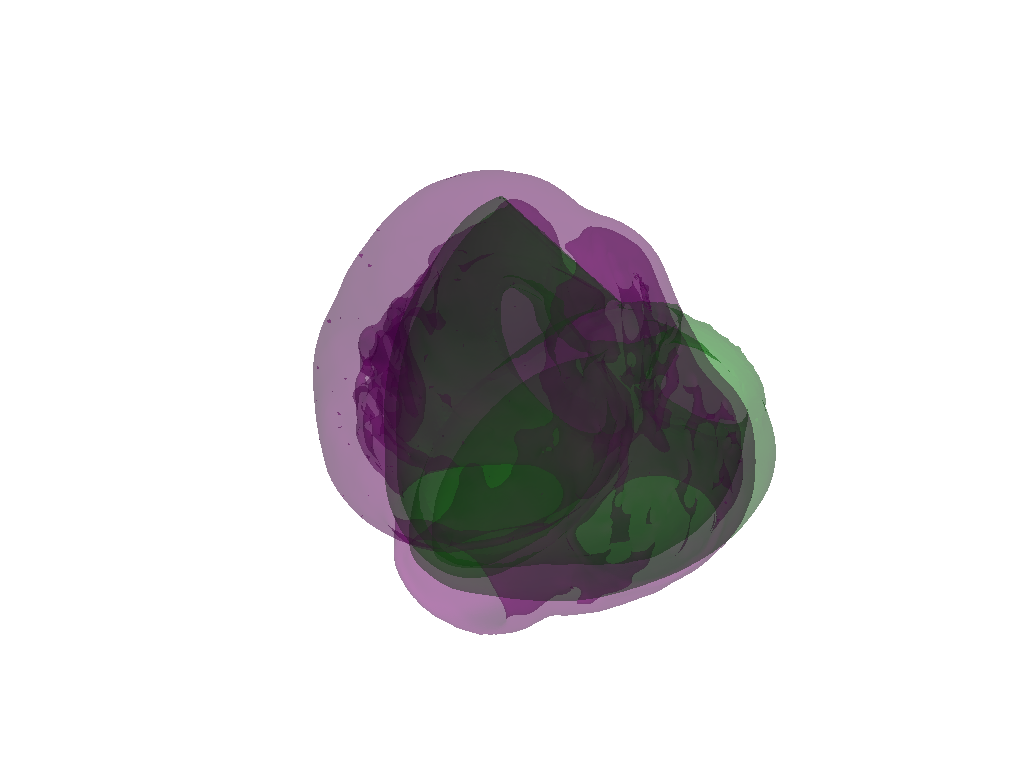

In [ ]:
p2 = pyvista.Plotter()

# Visualize the original moving model and the transformed model
# p2.add_mesh(model.mesh, color="green", opacity=0.1)
p2.add_mesh(mesh_b, color="purple", opacity=0.3)
p2.add_mesh(aligned, color="green", opacity=0.3)

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()